In [1]:
import sys
import shutil
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx

2025-07-11 14:13:05.494719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 14:13:05.532442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-11 14:13:05.532481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-11 14:13:05.533838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 14:13:05.542202: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def crop(img, kernel_size):
    # This function crops an image to the largest connected component (task 2).
    img_blur = t2.blur_image(img, kernel_size)
    img_thresh = t2.threshold_image(img_blur)
    num_labels, labels, stats, centroids = t2.connected_components(img_thresh)
    largest_component = t2.get_largest_component(stats)
    img_cropped = t2.crop_image(img, stats, largest_component)
    return img_cropped, stats, centroids

def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)

    return padded_image

def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))    

4/4 [==============================] - 1s 54ms/step


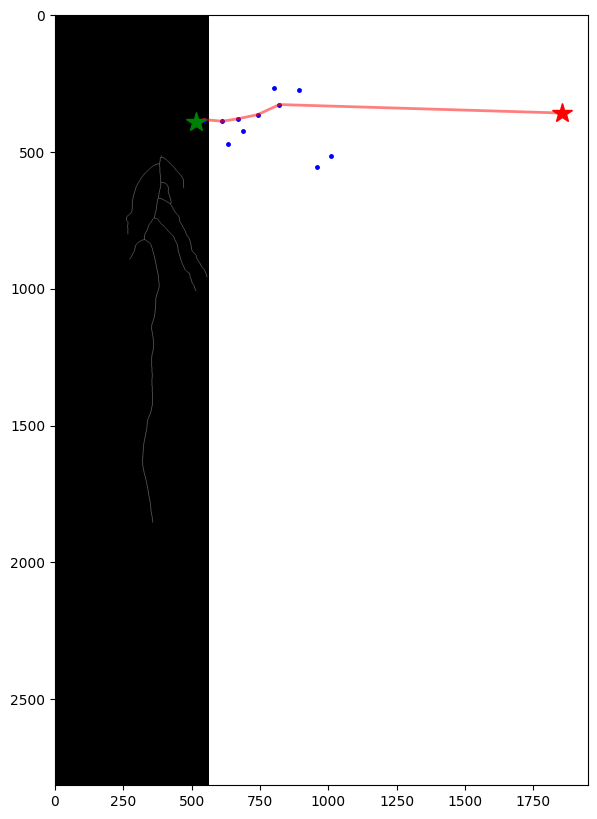

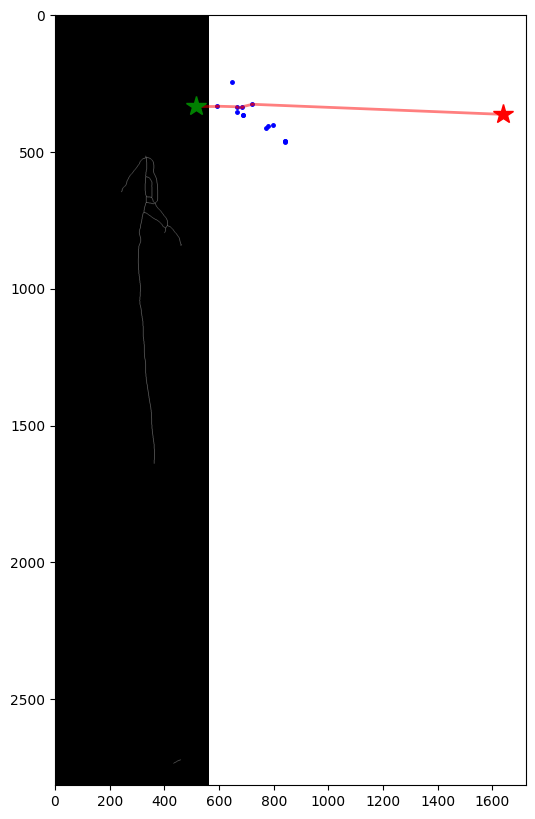

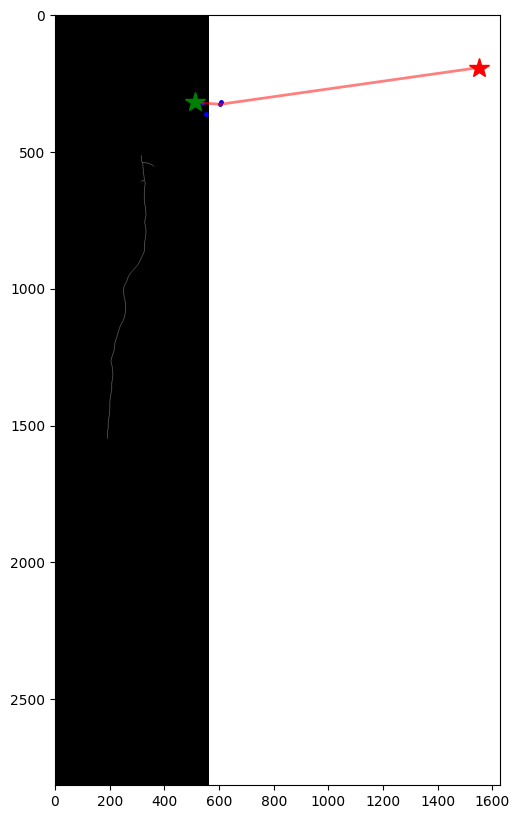

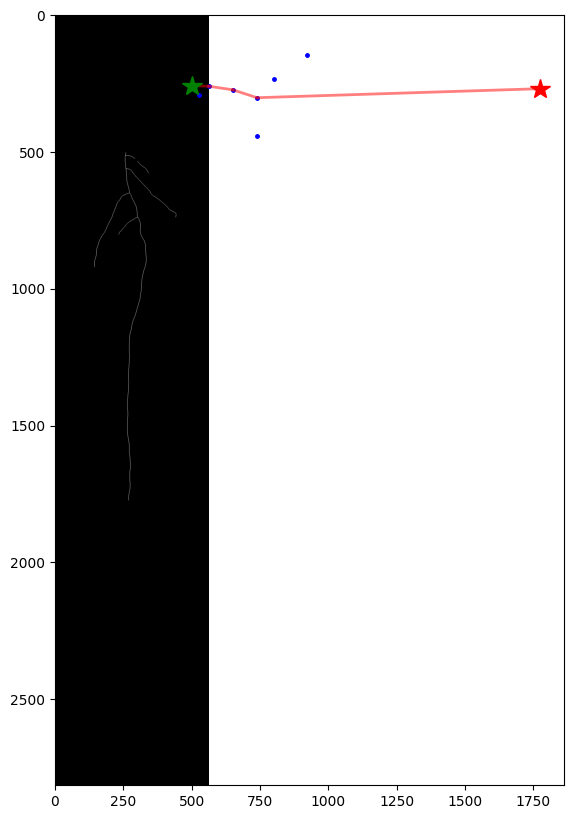

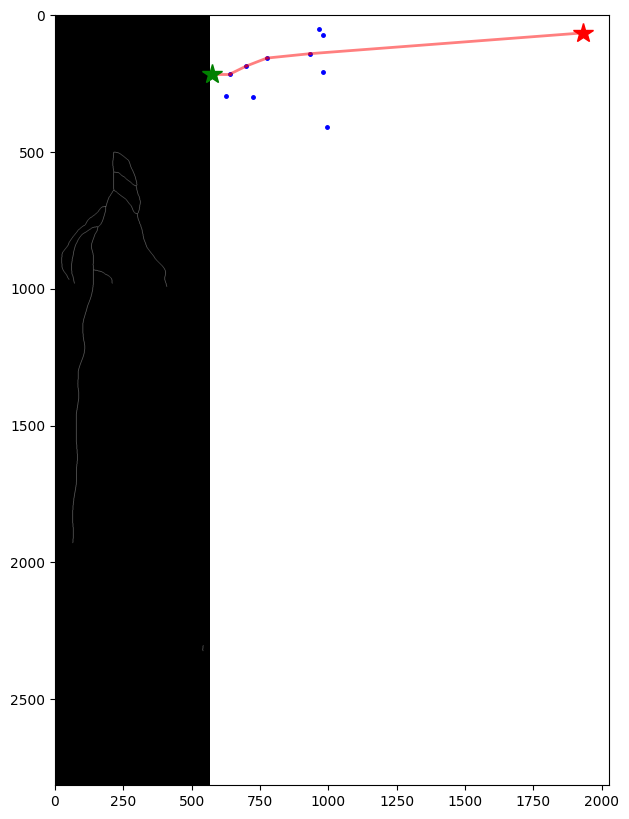

4/4 [==============================] - 0s 55ms/step


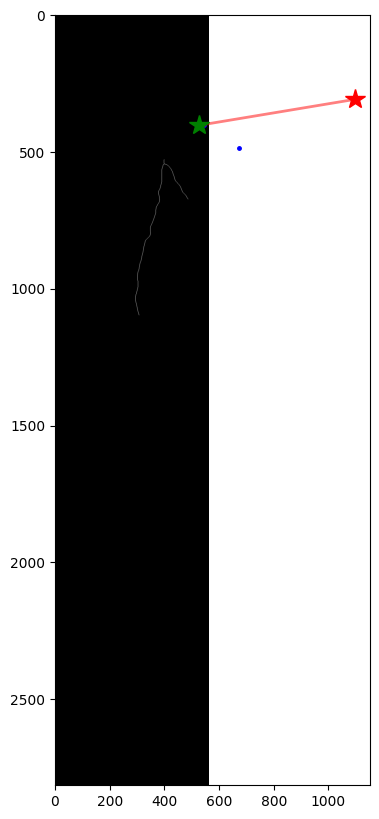

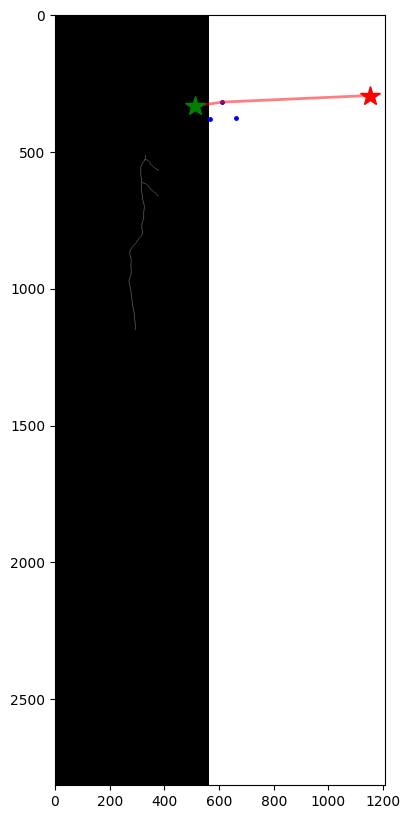

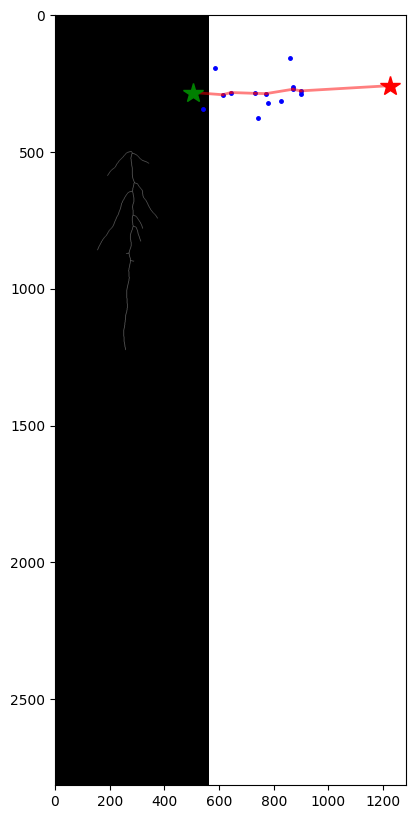

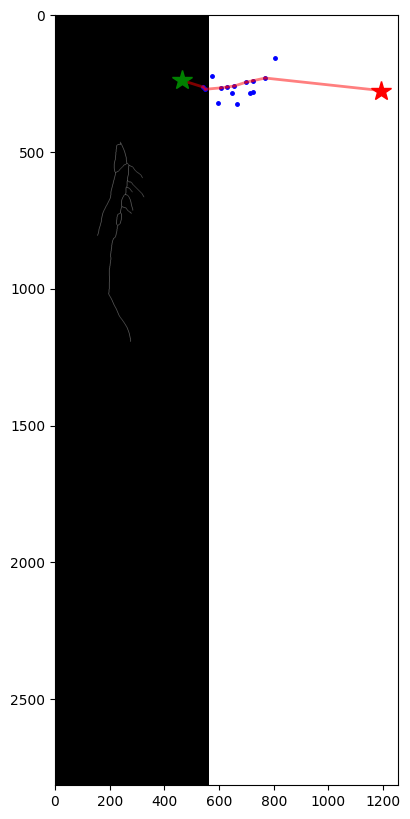

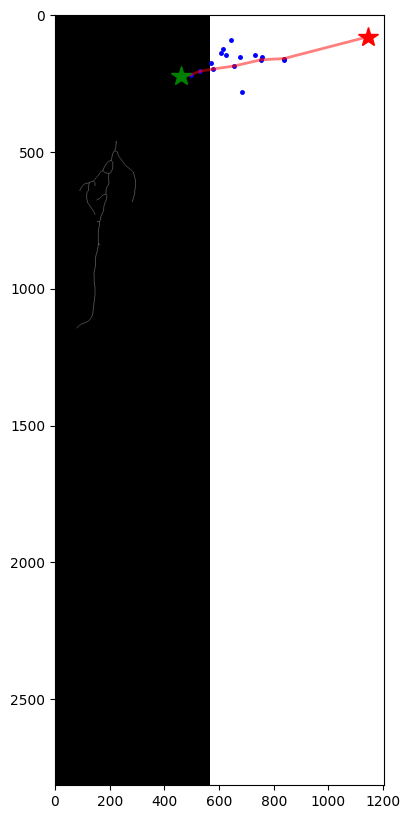

4/4 [==============================] - 0s 54ms/step


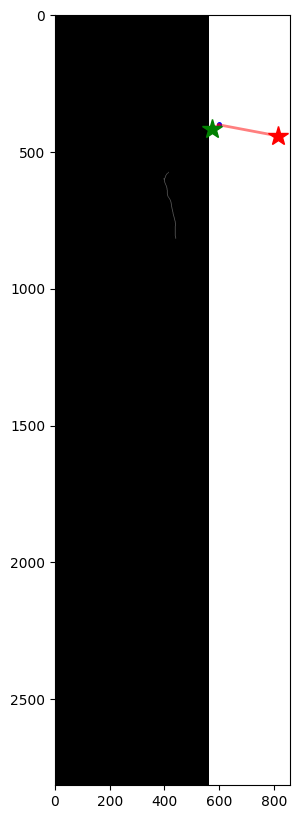

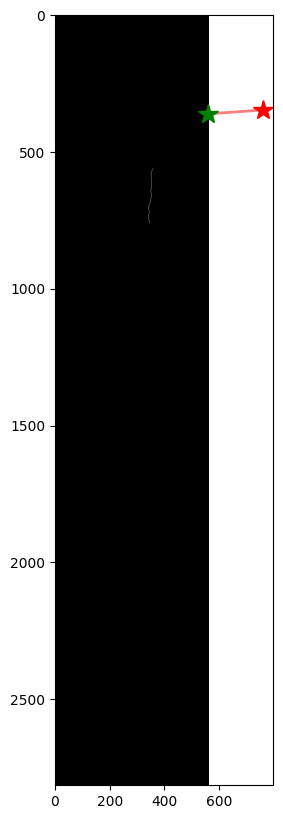

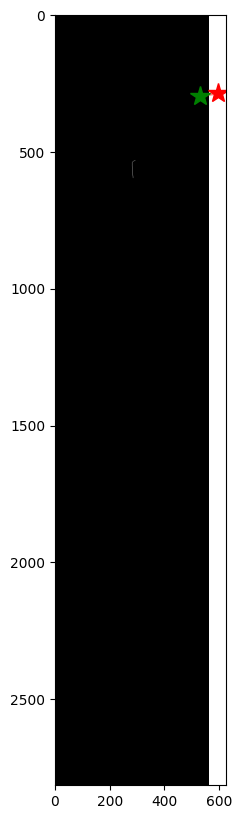

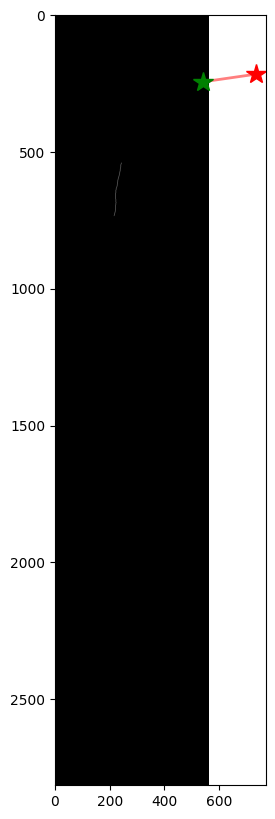

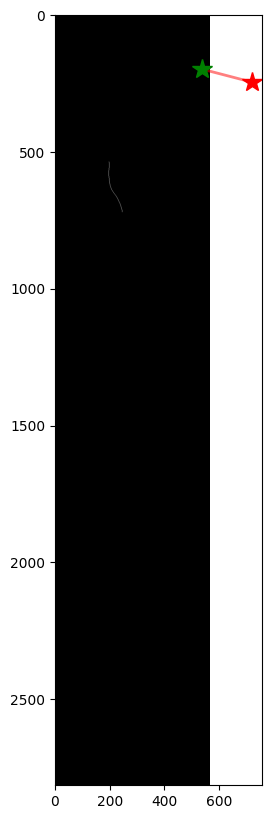

4/4 [==============================] - 0s 55ms/step


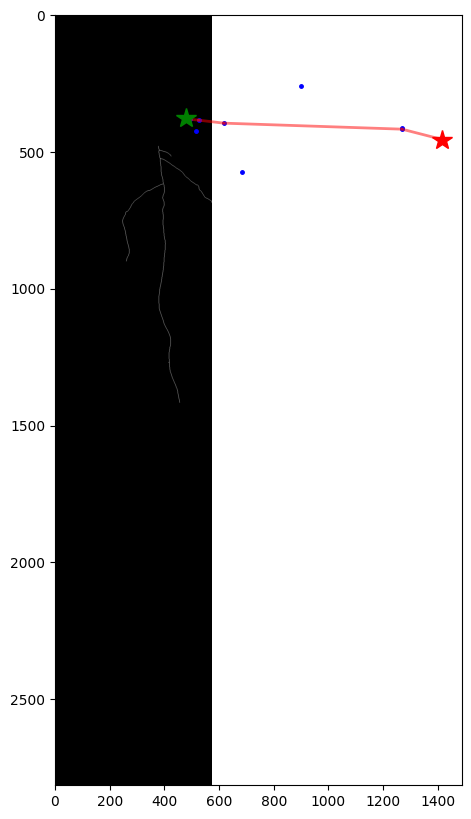

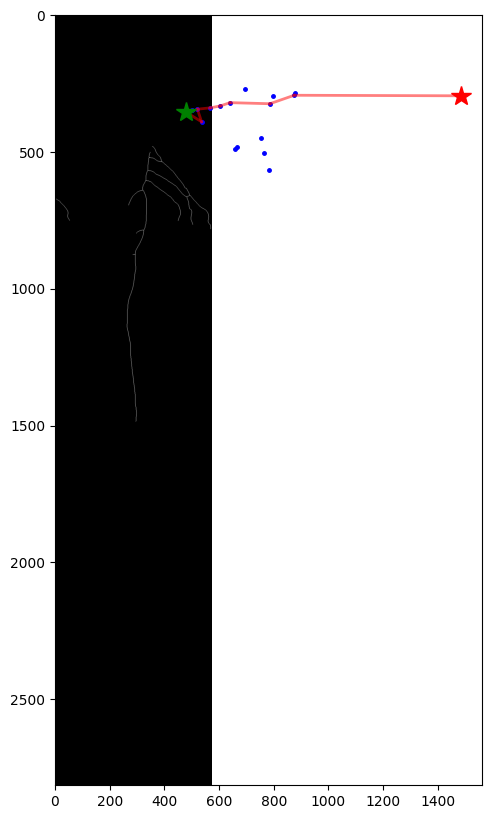

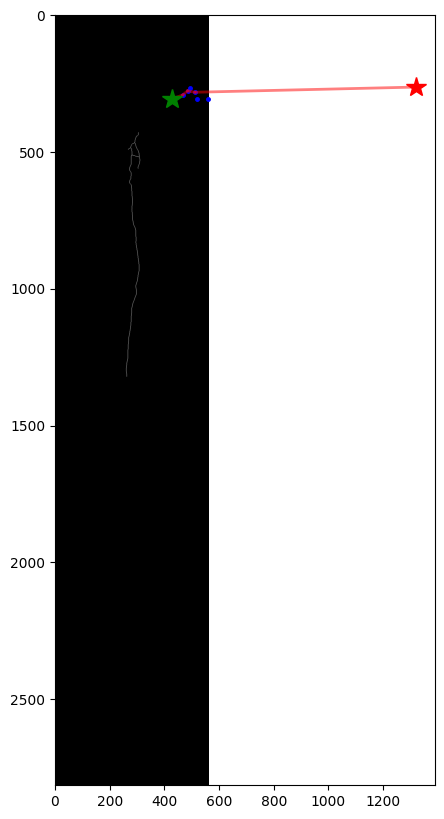

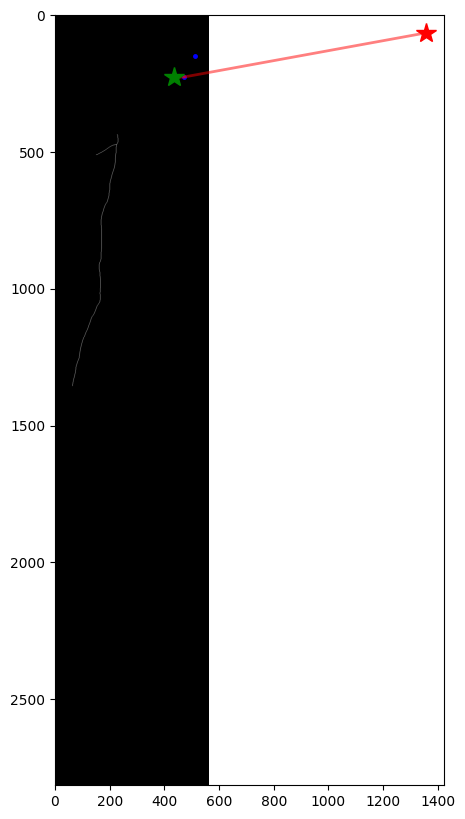

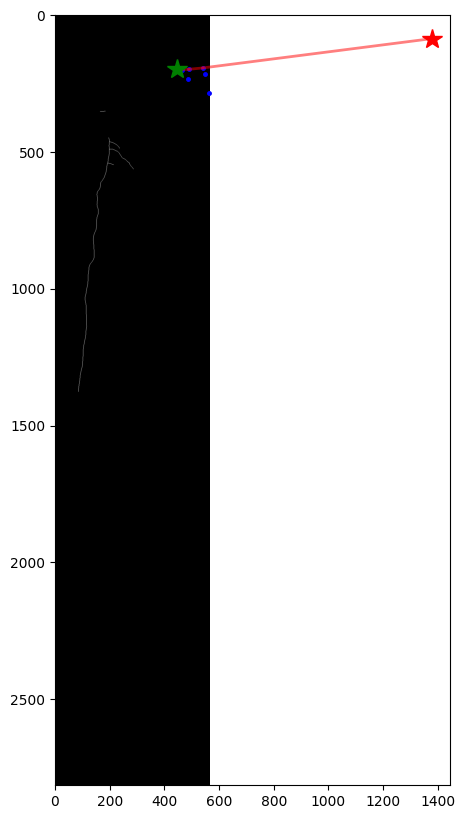

4/4 [==============================] - 1s 54ms/step


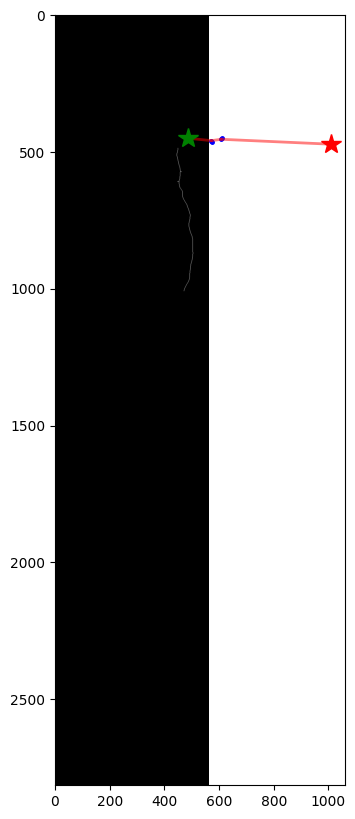

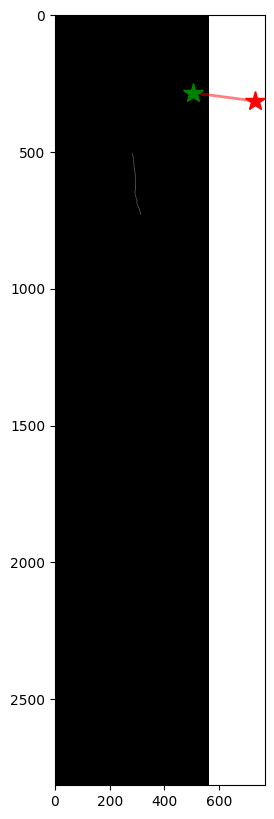

4/4 [==============================] - 1s 56ms/step


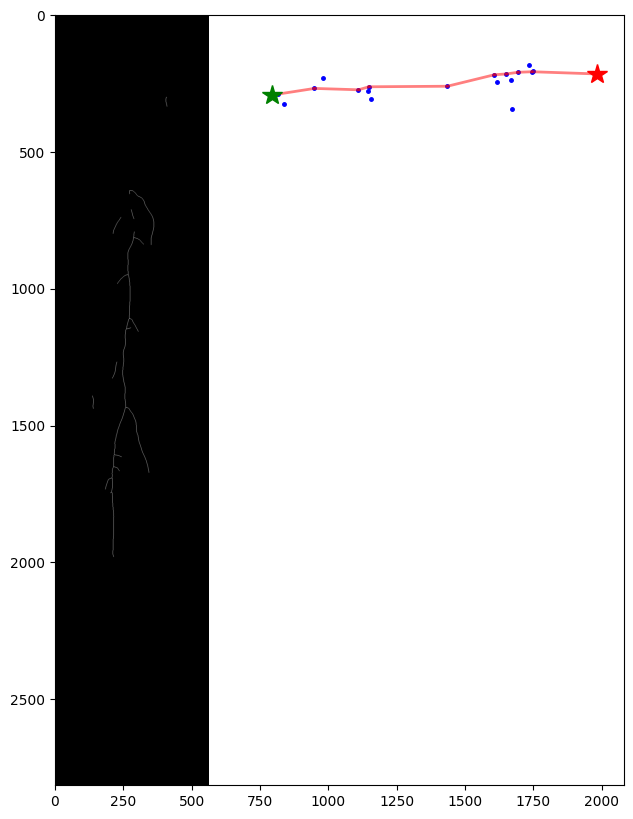

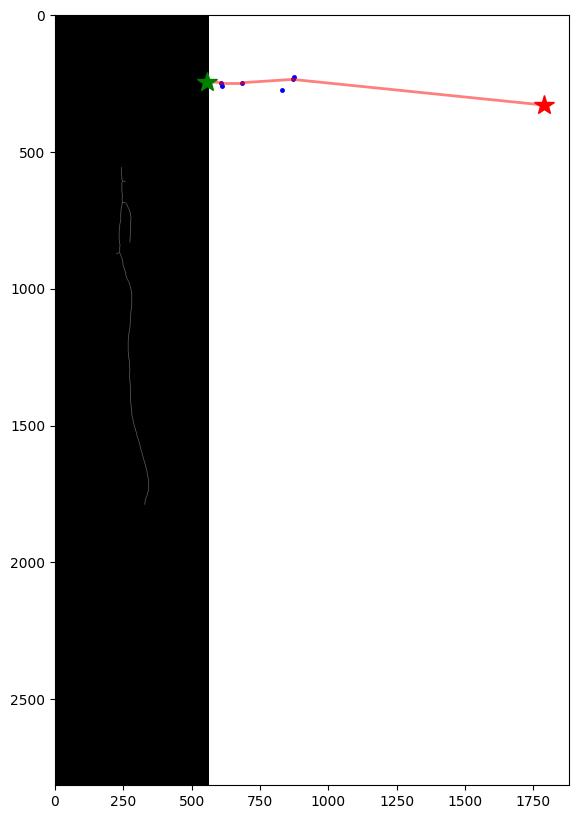

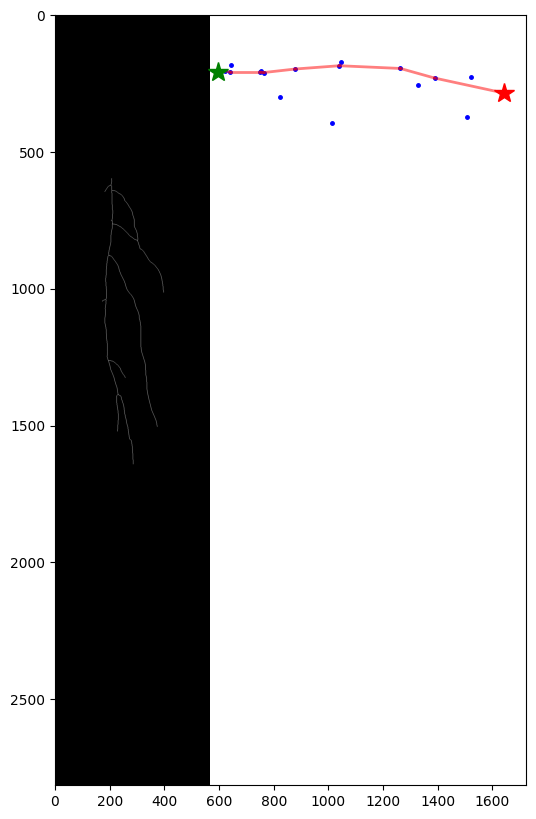

4/4 [==============================] - 0s 56ms/step


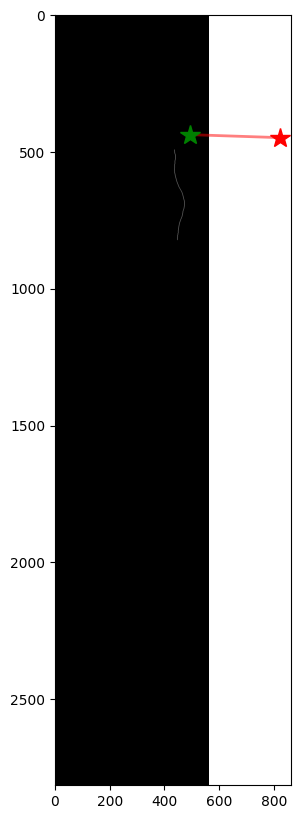

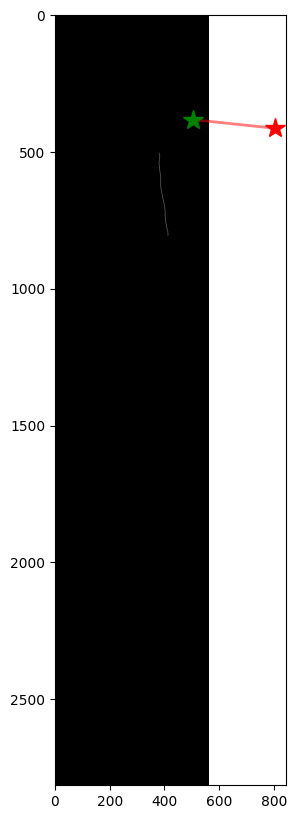

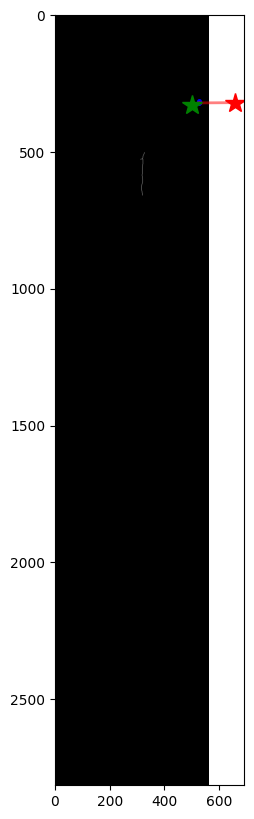

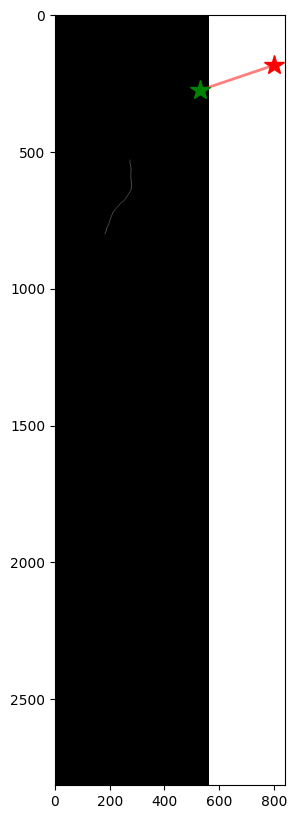

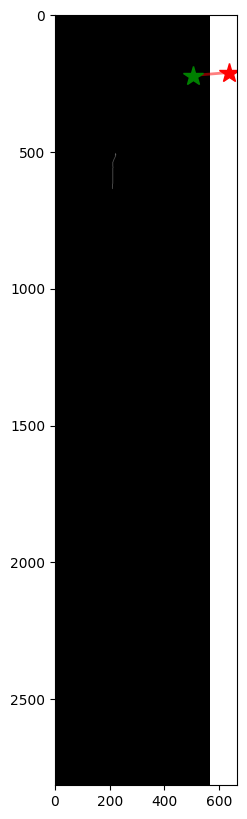

4/4 [==============================] - 0s 54ms/step


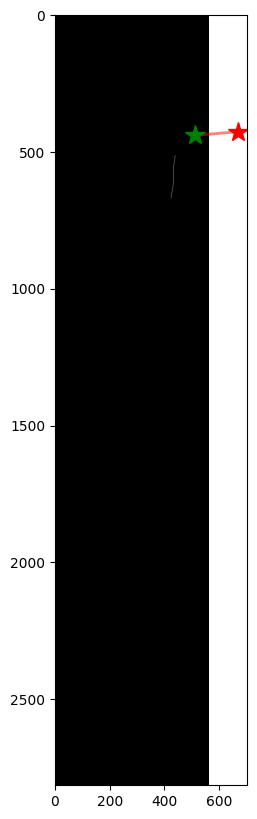

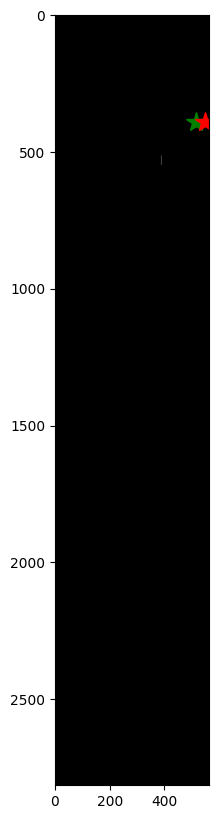

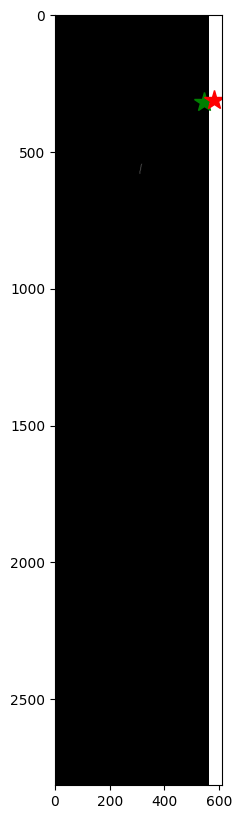

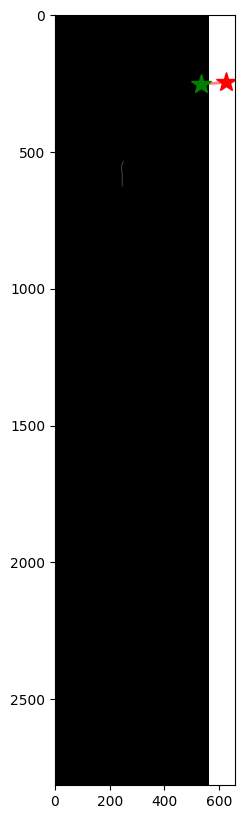

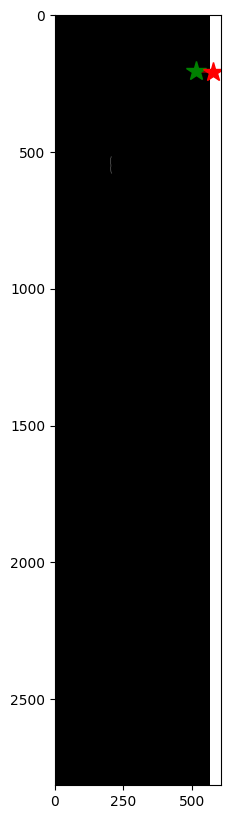

4/4 [==============================] - 1s 54ms/step


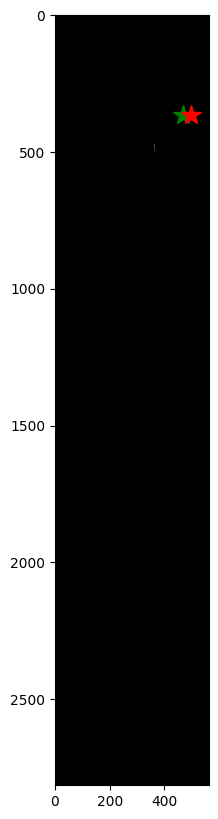

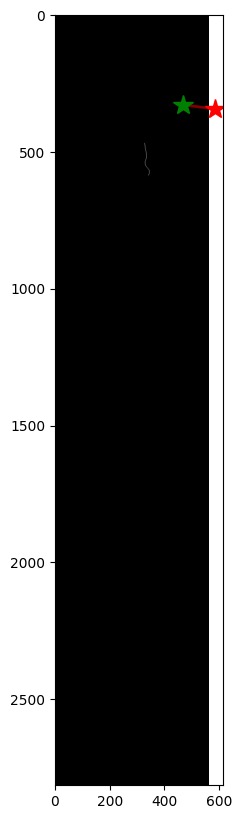

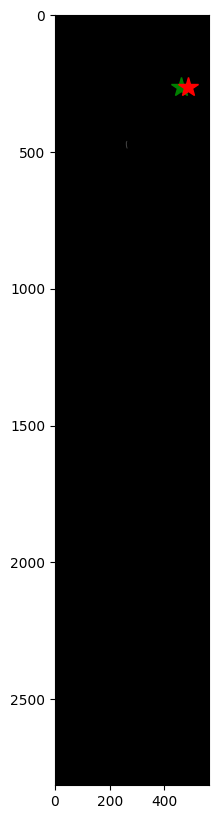

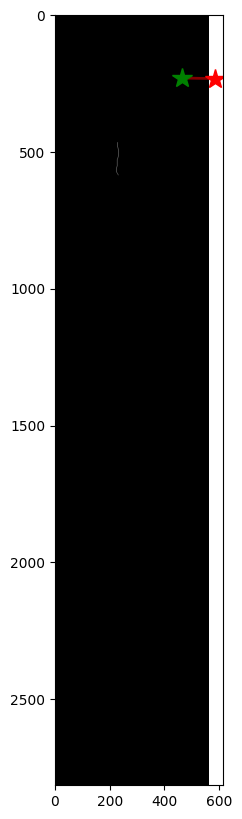

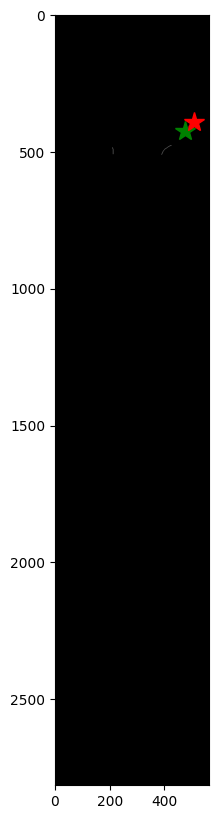

4/4 [==============================] - 0s 59ms/step


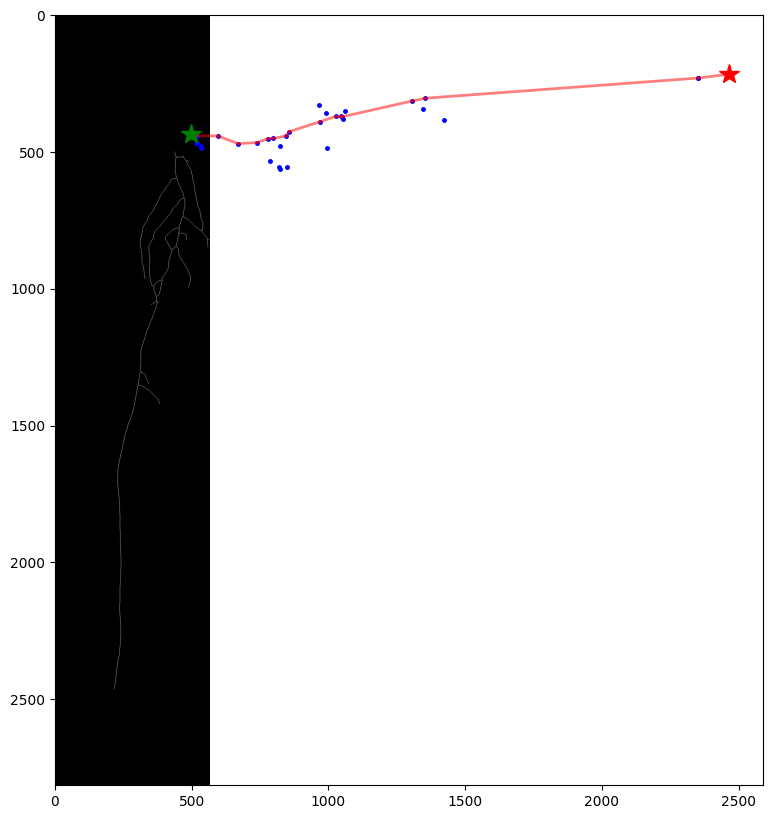

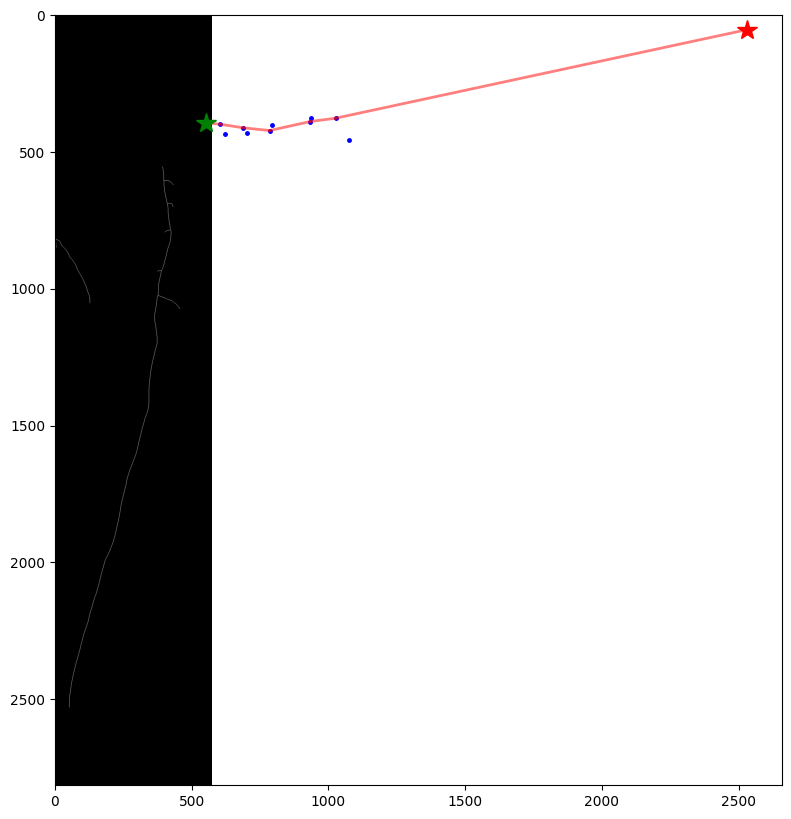

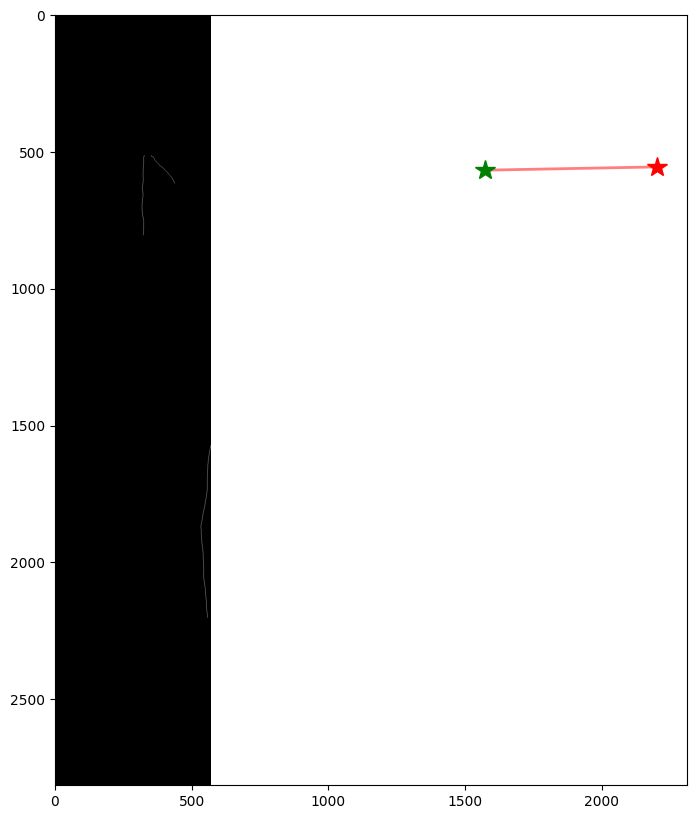

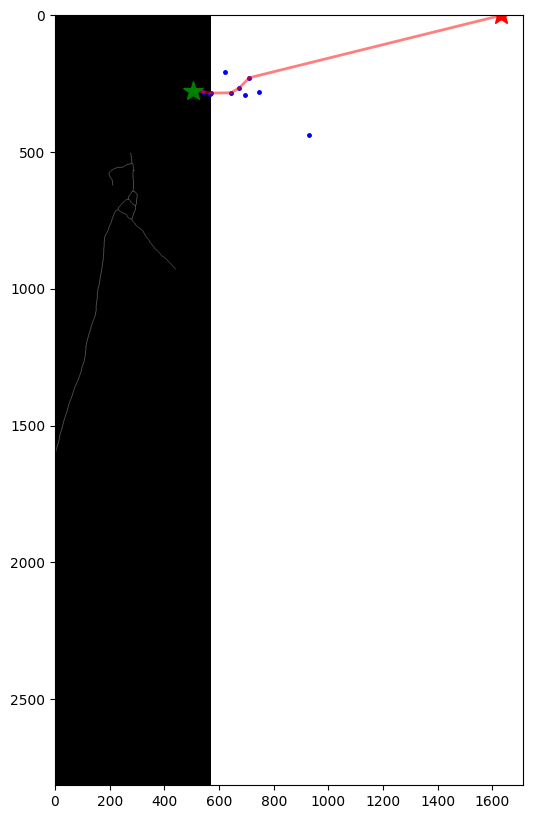

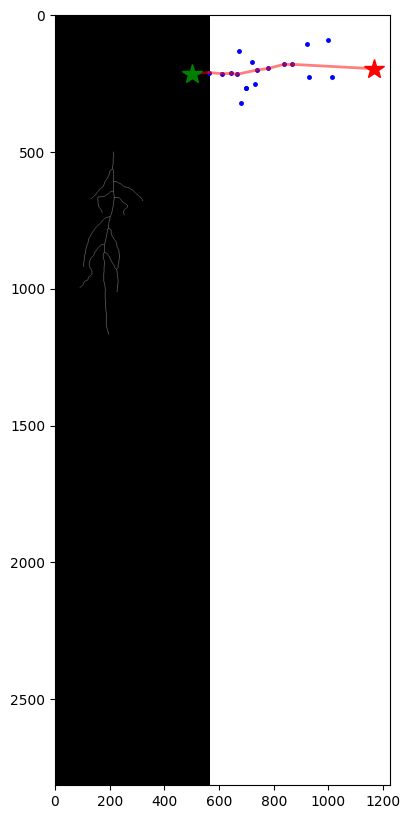

4/4 [==============================] - 0s 54ms/step


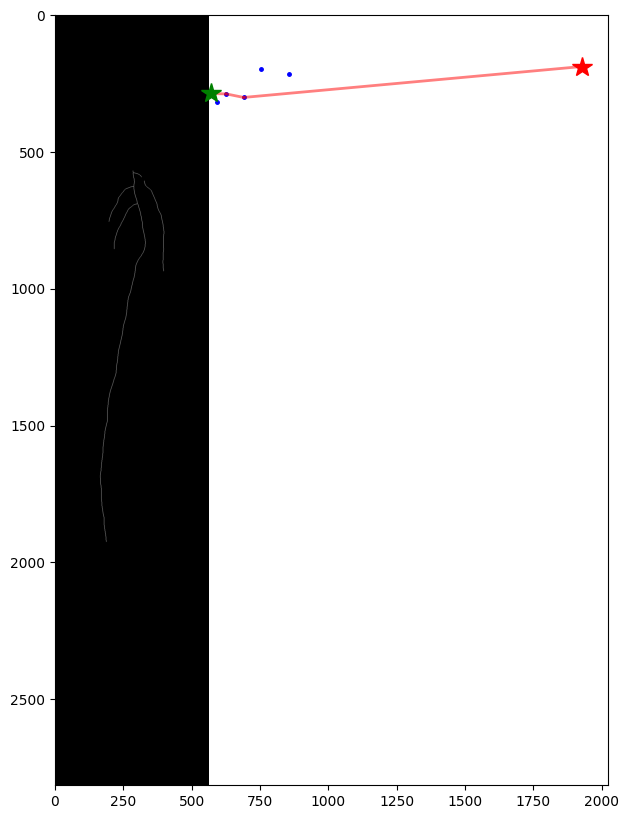

4/4 [==============================] - 0s 54ms/step


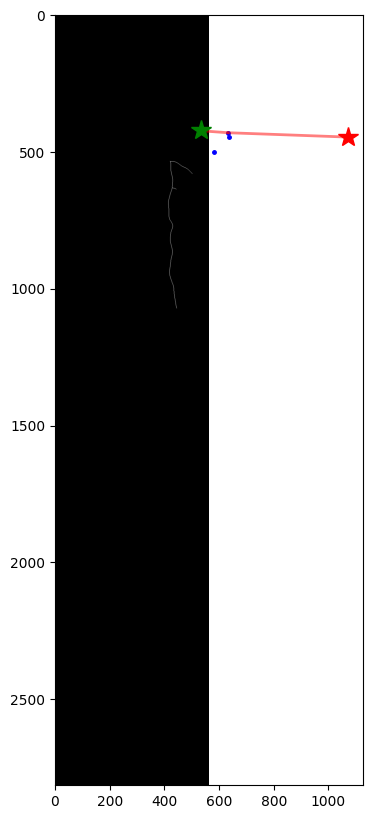

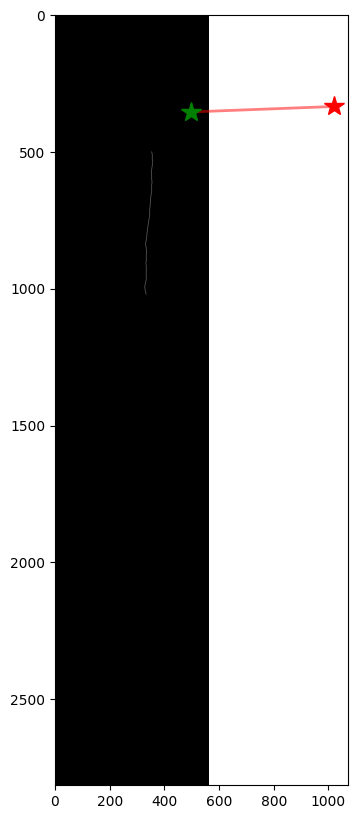

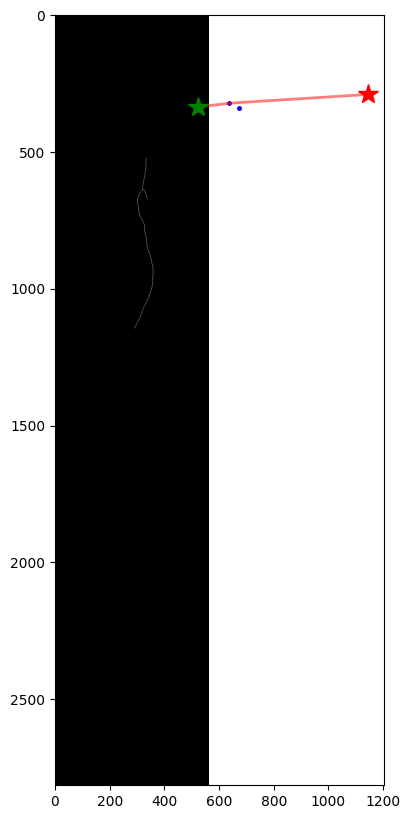

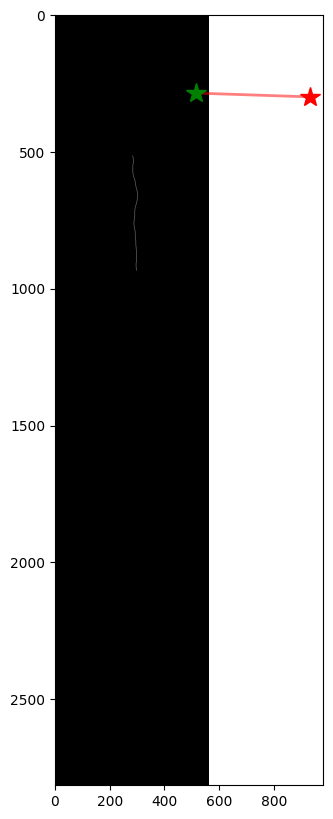

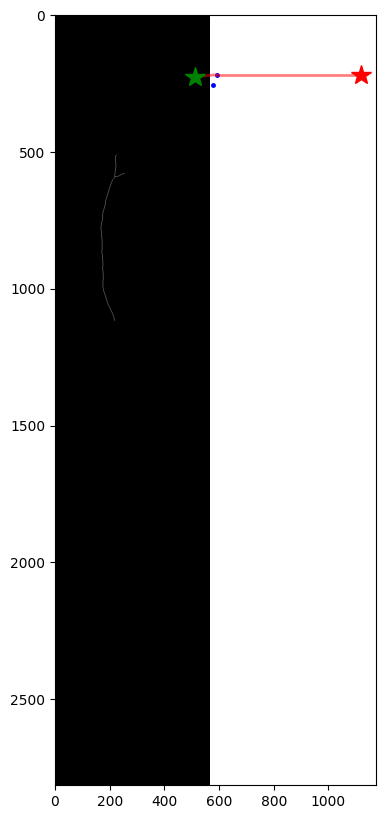

4/4 [==============================] - 0s 55ms/step


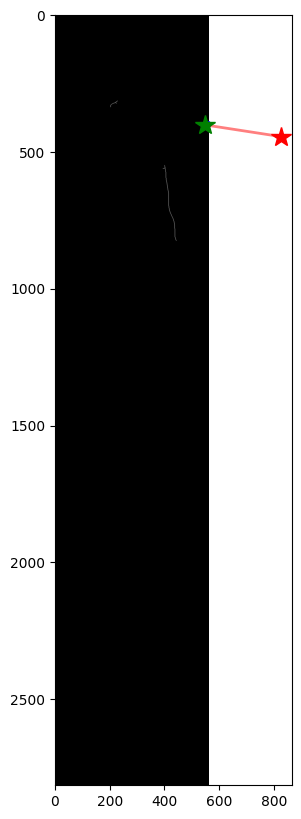

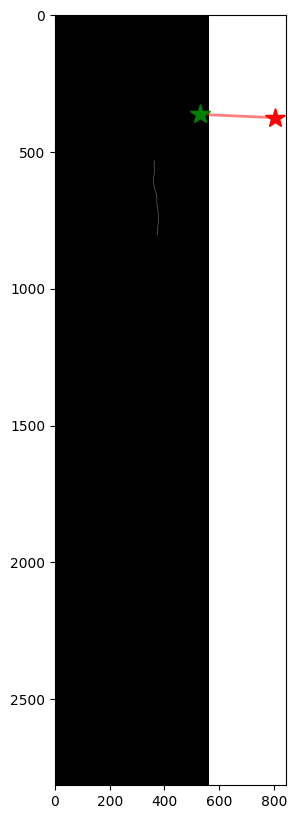

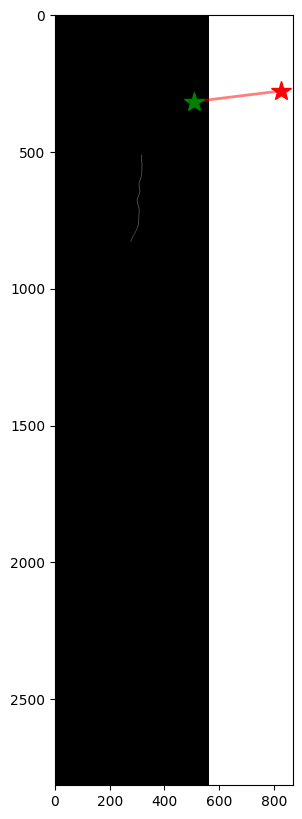

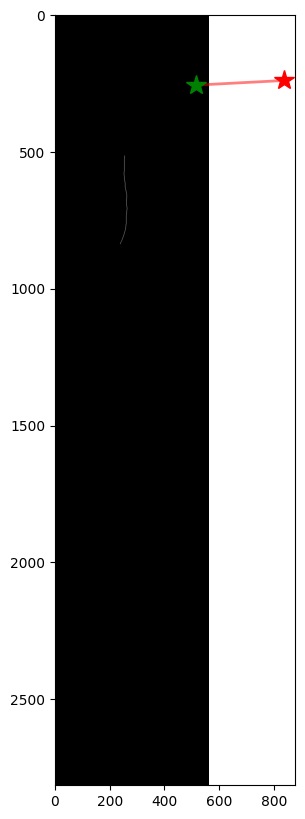

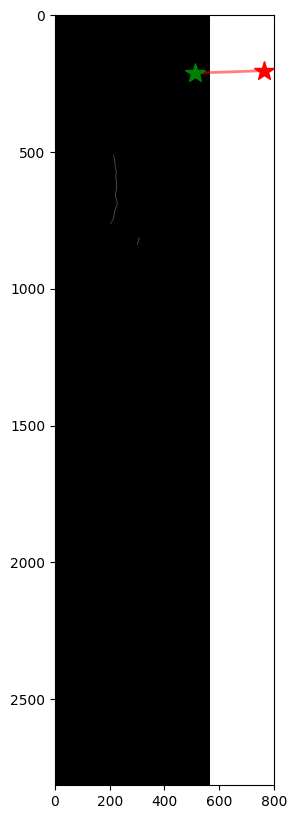

4/4 [==============================] - 0s 56ms/step


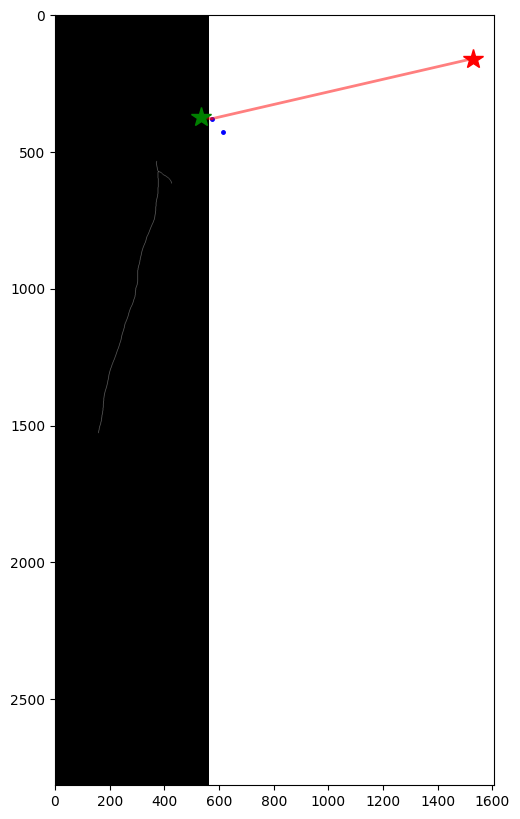

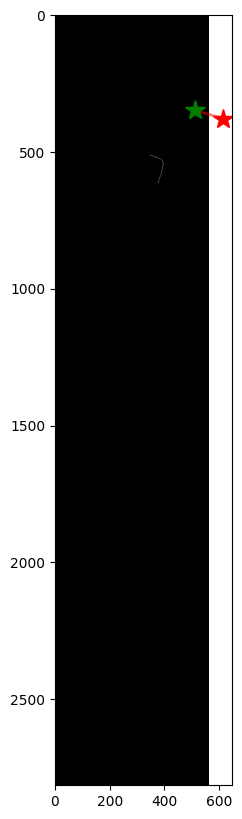

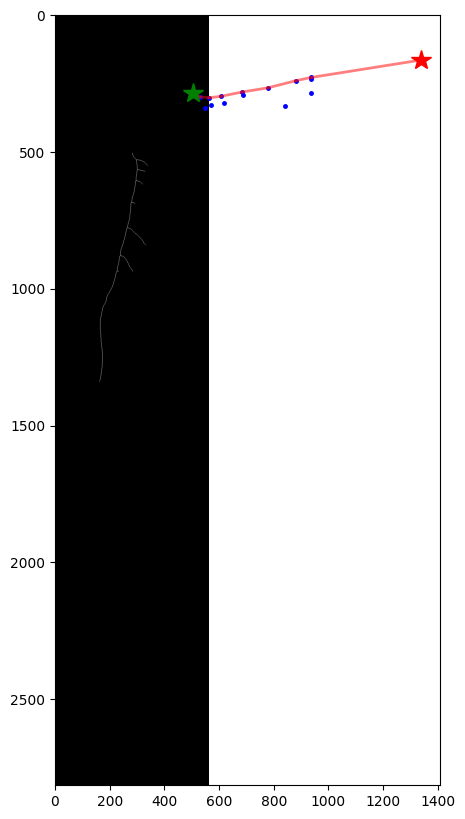

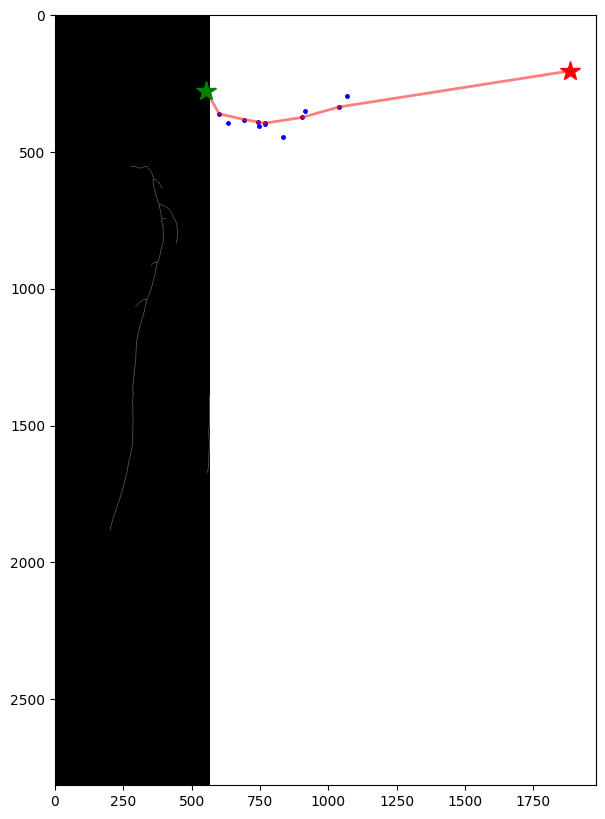

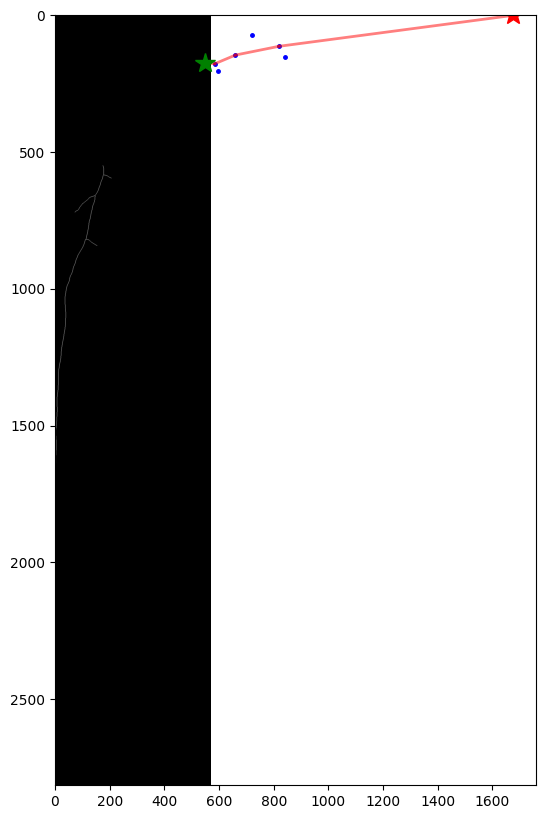

4/4 [==============================] - 0s 56ms/step


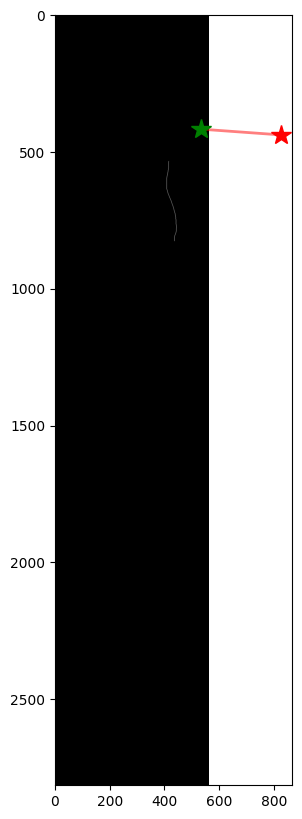

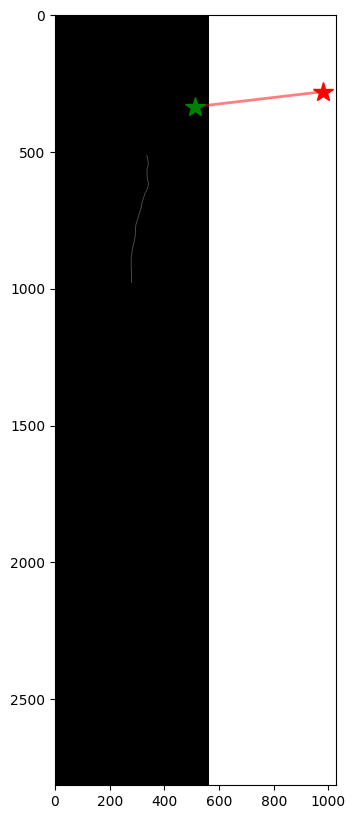

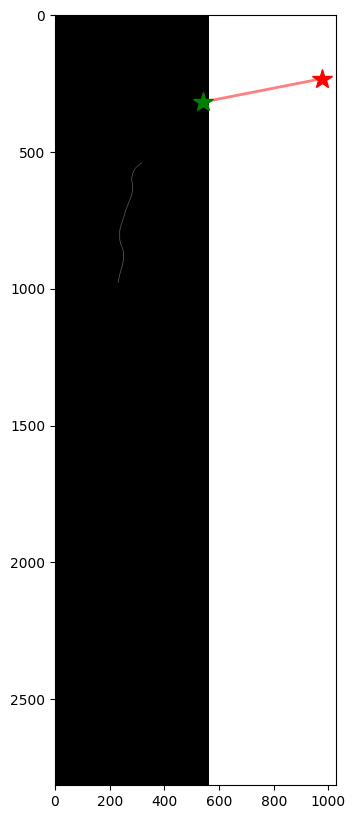

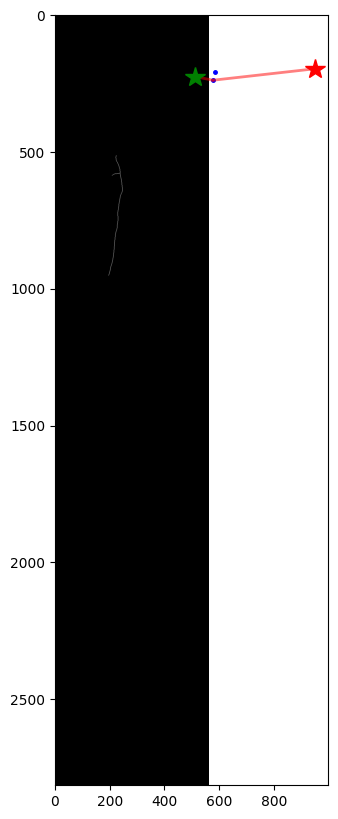

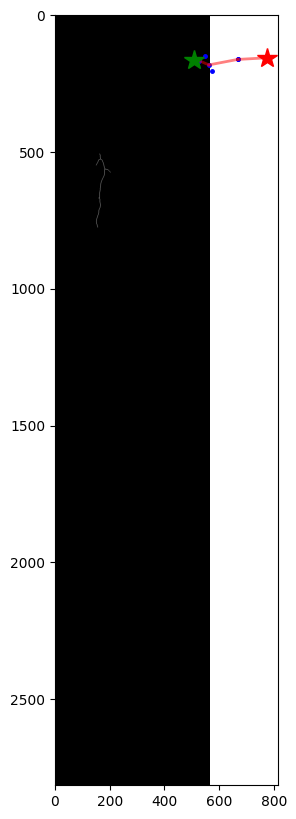

4/4 [==============================] - 1s 54ms/step


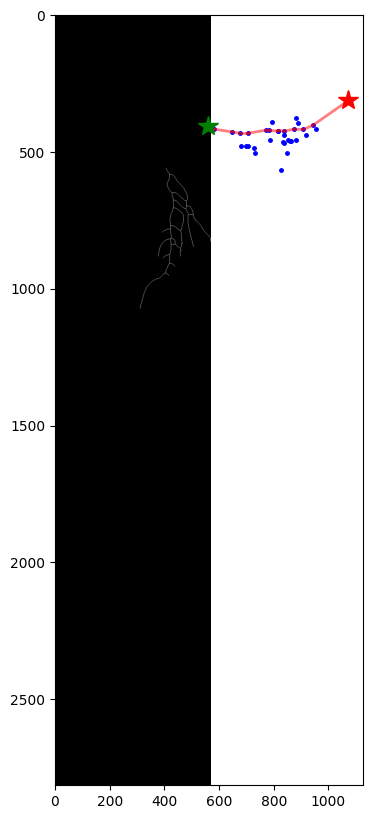

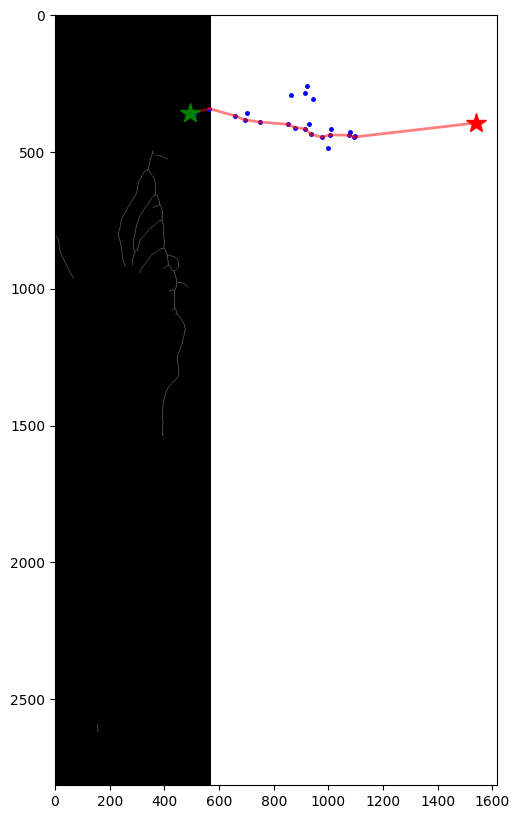

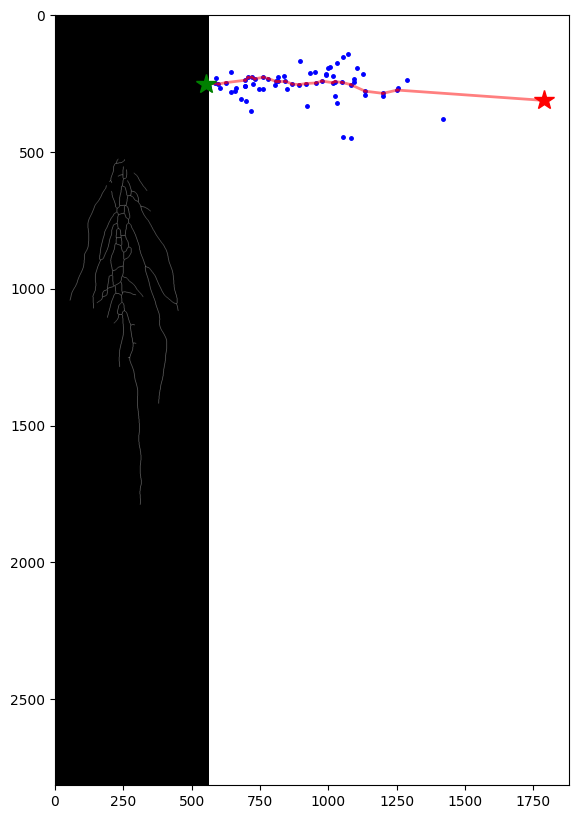

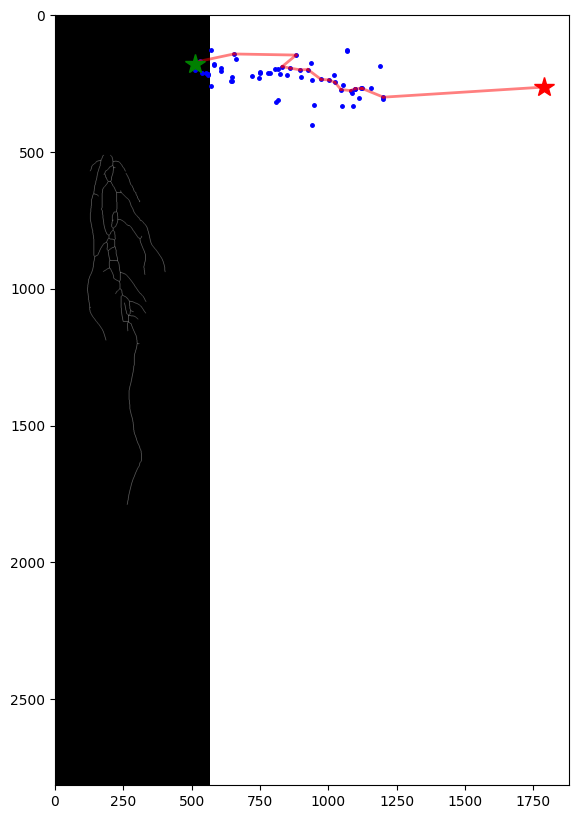

4/4 [==============================] - 1s 54ms/step


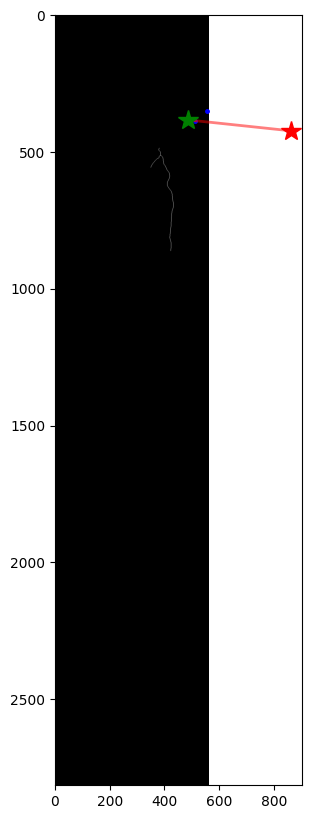

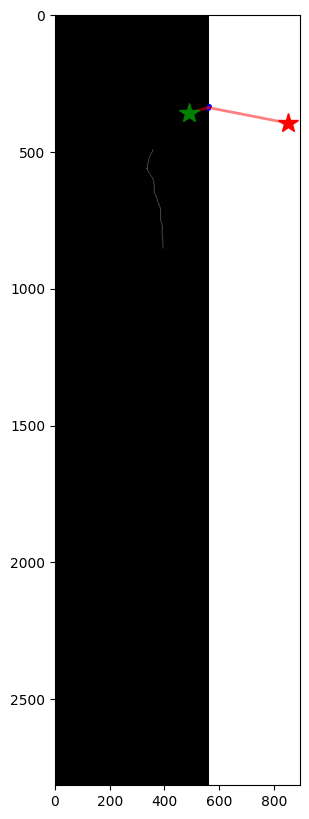

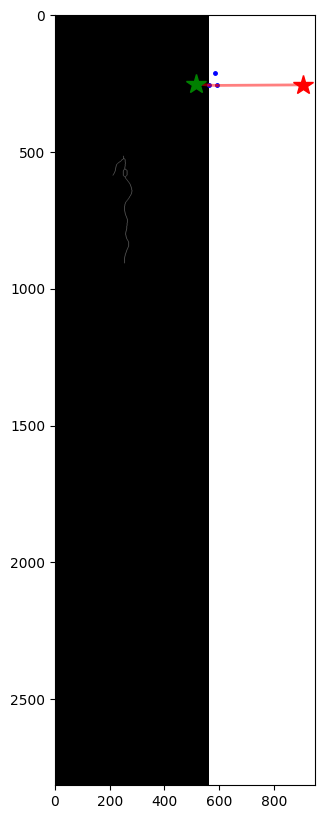

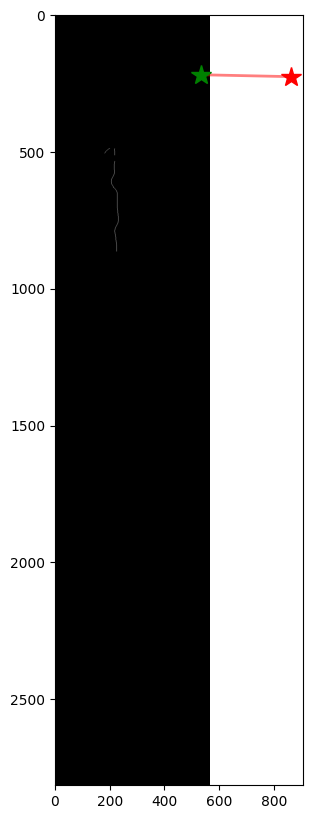

4/4 [==============================] - 0s 57ms/step


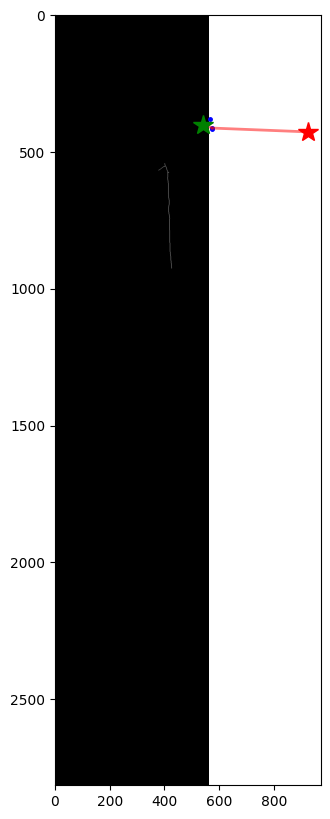

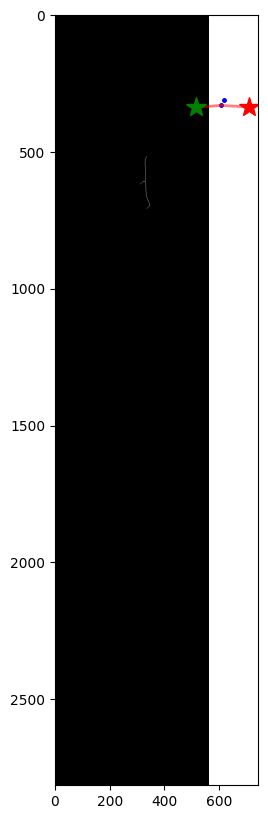

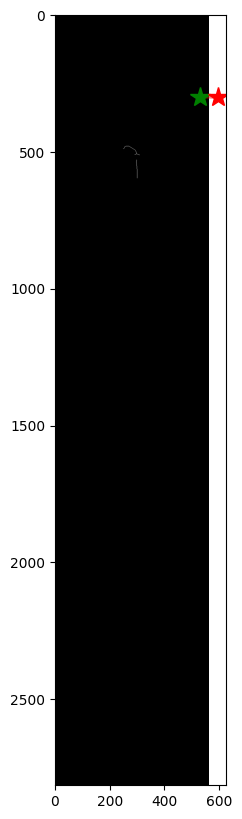

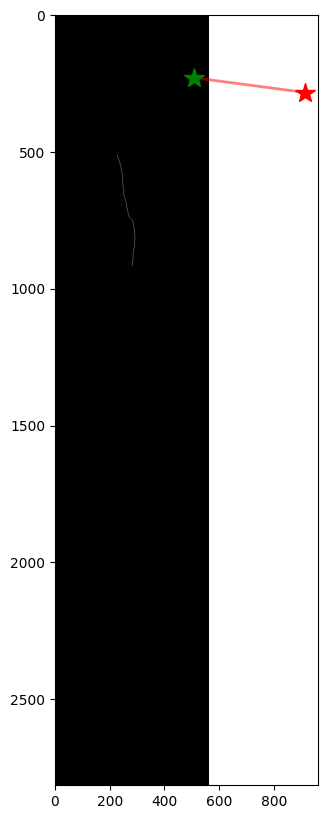

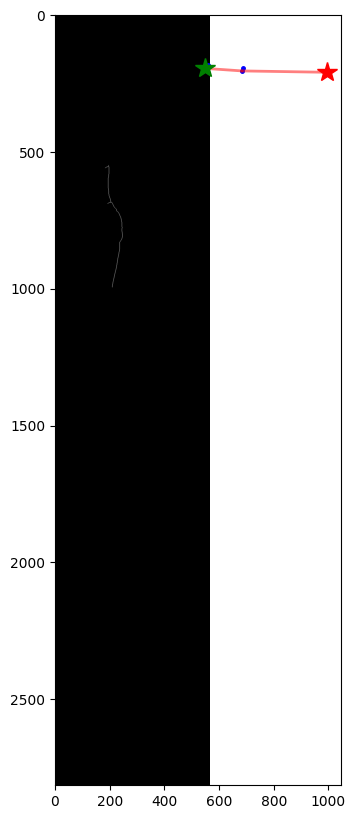

       Length (px)
count    90.000000
mean    560.751237
std     516.754289
min       0.000000
25%     138.405592
50%     407.095454
75%     948.174928
max    2151.383910


In [13]:
def pipeline(image_dir, kernel_size=5, patch_size=256):

    # Loading the model outside the for loop so that it takes less time to run the code
    model_path = "test_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    # Creating a disctionary with each plant and its length
    measurements = list()
    
    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            
            ### IMAGE PREPROCESSING ###
            
            image = os.path.join(image_dir, file)
            image = cv2.imread(image, 0) # Reading the images
            image_cropped, _, _ = crop(image, kernel_size=kernel_size)
            #cv2.imwrite("data_v3_unprocessed/train/images/images", image_cropped)

            # Converting the image to 3 channels
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            # Normalizing the data
            image_np = np.array(image_color)
            image_np = image_np / 255
            # Padding
            image_padded = padder(image_np, patch_size = patch_size)
            # Patchifying
            patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
            #Calculate the expected output shape based on the image and patch sizes
            expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
            patches = patches.reshape(-1, patch_size, patch_size, 3)

            ### GETTING THE PREDICTION ###
            
            predicted_patches = model.predict(patches)

            # Reshaping the patches into the correct format for the unpatchify
            predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
            predicted_patches = predicted_patches[:, :, :, :, 0]

            # Unpatchifying the patches to get the image
            prediction = unpatchify(predicted_patches, image_padded.shape[:2])

            # The prediction is not bianry so I threshold the image.
            # I chose 0.6 as the threshold for more qualitative results.
            prediction_bool = prediction > 0.5
            prediction_clean = remove_small_objects(prediction_bool, min_size=100)
            
            # Convert to uint8 for OpenCV operations (cv2 expects uint8 for morphology)
            prediction_clean = prediction_clean.astype(np.uint8)
            
            # Now perform dilation and erosion
            kernel = np.ones((3, 3), np.uint8)
            prediction_d = cv2.dilate(prediction_clean, kernel, iterations=4)
            prediction_closed = cv2.erode(prediction_d, kernel, iterations=4)

            # Creating a black strip above the image for 300 pixels to remove some noise
            prediction_closed[:300, :] = 0
            if np.all(prediction_closed[1500, :] == 0):
                prediction_closed[1500:, :] = 0

            print(file, ":")
            cv2.imshow(prediction_closed)
            print()

df = pipeline('data_v1_unprocessed/train')

In [12]:
df = pd.read_csv('submission_16.csv')
df.describe()

,Length (px)
count,90.000000
mean,561.459787
std,516.094863
min,0.000000
25%,138.405592
50%,407.095454
75%,948.174928
max,2151.383910


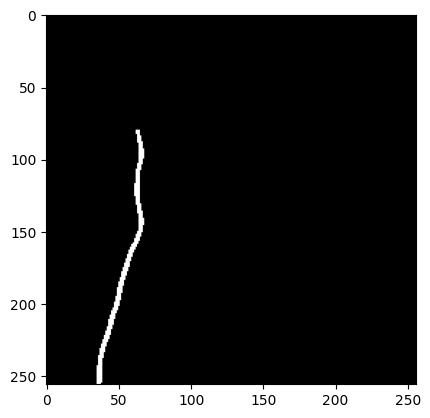

In [28]:
img = cv2.imread("data_v2_processed/train/images/images/28_13_08_09.png")
mask = cv2.imread("data_v2_processed/train/masks/masks/28_13_08_09.tif")

img = np.array(img)
mask = np.array(mask)

plt.imshow(mask)

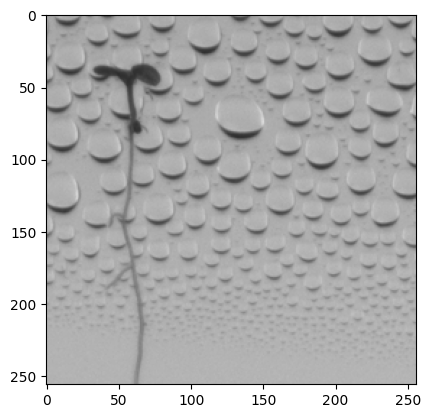

In [16]:
plt.imshow(img, cmap='gray')